# Imports

In [2]:
import glob
import os
import cv2
import xml.etree.ElementTree as ET
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocess 'documents'
I wanted to train an object detector to detect characters in words. But there was no dataset containing only words.
Therefore, I decided to crop words from some documents from this dataset: https://www.kaggle.com/datasets/shaz13/real-world-documents-collections

The documents are in the 'documents' directory. I annotated words from them and down below cropped words from the documents
using the annotations.

In [3]:
"""
Get paths to images and annotations
"""

# Paths
path_documents = glob.glob('documents/*.jpg')
path_annotations = glob.glob('documents/*.xml')
print(path_documents)
print(path_annotations)

['documents\\0.jpg', 'documents\\1.jpg', 'documents\\2.jpg', 'documents\\3.jpg', 'documents\\4.jpg', 'documents\\5.jpg']
['documents\\0.xml', 'documents\\1.xml', 'documents\\2.xml', 'documents\\3.xml', 'documents\\4.xml', 'documents\\5.xml']


In [4]:
"""
Using the annotated xml files crop the words out of the documents.
"""

# Read xml files in 'path_annotation' and return bounding boxes
def read_xml(path_annotation):
    # Read xml file
    tree = ET.parse(path_annotation)
    root = tree.getroot()
    # Create list
    list_bbox = []

    # Get filename and bounding boxes coordinates
    for obj in root.iter('object'):
        xmin = obj.find('bndbox').find('xmin').text
        ymin = obj.find('bndbox').find('ymin').text
        xmax = obj.find('bndbox').find('xmax').text
        ymax = obj.find('bndbox').find('ymax').text
        list_bbox.append([xmin, ymin, xmax, ymax])
    return list_bbox

# Crop image using annotations
def crop(image, bounding_box):
    xmin = int(bounding_box[0])
    ymin = int(bounding_box[1])
    xmax = int(bounding_box[2])
    ymax = int(bounding_box[3])
    cropped_image = image[ymin:ymax, xmin:xmax]
    return cropped_image

# Read xmls and crop bounding boxes from images
cropped_words = []
for path_annotation, path_image in zip(path_annotations, path_documents):
    # Read xml file
    bounding_boxes = read_xml(path_annotation)
    # Read image
    image = cv2.imread(path_image)
    # Crop bounding boxes from image
    for bounding_box in bounding_boxes:
        word = crop(image, bounding_box)
        cropped_words.append(word)

cropped_words = np.array(cropped_words, dtype=object)
print(cropped_words.shape)

(857,)


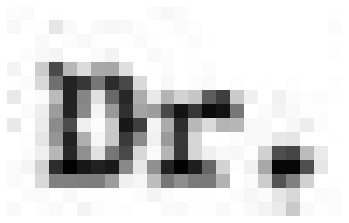

In [5]:
"""
View a cropped word
"""
# Function to view a image
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# View first image
plot_image(cropped_words[0])


In [6]:
"""
Resize images to 608x608 to fit the object detection model
"""
resized_words = []
for cropped_word in cropped_words:
    resized_word = cv2.resize(cropped_word, (608, 608))
    resized_words.append(resized_word)

resized_words = np.array(resized_words)
print(resized_words.shape)


(857, 608, 608, 3)


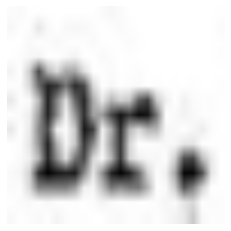

In [7]:
"""
View a resized word
"""

# View first image
plot_image(resized_words[0])

In [15]:
"""
Threshold images to remove noise and make them binary.
"""

# Thresholding images
thresholded_words = []
for resized_word in resized_words:
    thresholded_word = cv2.threshold(resized_word, 127, 255, cv2.THRESH_BINARY_INV)[1]
    thresholded_words.append(thresholded_word)

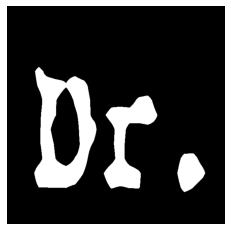

In [25]:
"""
View first thresholded word
"""

# View first image
plot_image(thresholded_words[0])

In [27]:
# Taking the first 400 words
images_to_save = thresholded_words[:400]

In [28]:
"""
Saving images to 'words' directory
"""

# Directory management
if not os.path.exists('words'):
    os.makedirs('words')
if not os.path.exists('words/annotations'):
    os.makedirs('words/annotations')

if os.path.exists('words/images'):
    shutil.rmtree('words/images')
os.makedirs('words/images')

# Save images
for index, image in enumerate(images_to_save):
    cv2.imwrite('words/images/' + str(index) + '.jpg', image)

# Preprocess 'words'
I had then created a dataset containing only words. I wanted to train an object detector to detect characters in words.
So I labeled them (in yolo format) and saved the annotations to 'words/annotations' directory.

Then I split the data into training, validation and test sets as shown in the 'words_v2' directory. I also created a
data.yaml file to describe the dataset to the object detection model.

